In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
figure_format = '/cndd2/fangming/projects/miniatlas/results/figures/{}.pdf'

### Gene annot 

In [75]:
f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
print(df_genes.shape)
df_genes.head()


df_genes_v2 = df_genes.groupby('gene_name').first()
print(df_genes_v2.shape)
df_genes_v2.head()

(53379, 8)
(53278, 7)


,gene_id,chr,start,end,strand,gene_type,gid
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,ENSMUSG00000109644
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,ENSMUSG00000108652
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,ENSMUSG00000007777
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,ENSMUSG00000086714
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,ENSMUSG00000043644


### Load data

In [32]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Patchseq/mini-atlas-meta-data.csv' 
meta = pd.read_csv(f, sep='\t', index_col='Cell')
print(meta.columns)
print(meta.shape)
meta.head()

Index(['Number', 'Date', 'Sample', 'Mouse', 'Mouse date of birth', 'Mouse age',
       'Targeted layer', 'Cre', 'Number of genes detected', 'RNA family',
       'RNA type', 'RNA type confidence', 'RNA type top-3', 'ALM/VISp top-3',
       'Length (bp)', 'Yield (pg/µl)', 'User', 'Hold Time (min)',
       'Soma depth (µm)', 'Soma depth (4x)', 'Cortical thickness (4x)',
       'Cortical thickness (µm)', 'Traced', 'Exclusion reasons'],
      dtype='object')
(1320, 24)


,Number,Date,Sample,Mouse,Mouse date of birth,Mouse age,Targeted layer,Cre,Number of genes detected,RNA family,...,Length (bp),Yield (pg/µl),User,Hold Time (min),Soma depth (µm),Soma depth (4x),Cortical thickness (4x),Cortical thickness (µm),Traced,Exclusion reasons
Cell,,,,,,,,,,,,,,,,,,,,,
20171204_sample_2,1,2017-12-04,sample 2,mouse_GTOKH,2017-10-29,36,5,PV-,10090,PT,...,1955,95.19,Fede,8.0,736.7,271.0,535.8,1478.808,y,NaN
20171204_sample_4,2,2017-12-04,sample 4,mouse_GTOKH,2017-10-29,36,5,PV-,10882,IT,...,1887,80.22,Fede,9.0,726.2,285.7,545.9,1506.684,y,NaN
20171204_sample_5,3,2017-12-04,sample 5,mouse_GTOKH,2017-10-29,36,5,PV-,14950,IT,...,1869,439.16,Fede,8.0,659.8,241.8,530.4,1463.904,y,NaN
20171204_sample_6,4,2017-12-04,sample 6,mouse_GTOKH,2017-10-29,36,5,PV-,10688,PT,...,1999,211.71,Fede,8.0,571.7,210.0,501.1,1383.036,y,NaN
20171207_sample_1,5,2017-12-07,sample 1,mouse_UGZSW,2017-09-18,80,5,SST-,16310,PT,...,1884,986.46,Fede,10.0,772.4,288.9,477.1,1316.796,y,NaN


In [107]:
meta.columns

Index(['Number', 'Date', 'Sample', 'Mouse', 'Mouse date of birth', 'Mouse age',
       'Targeted layer', 'Cre', 'Number of genes detected', 'RNA family',
       'RNA type', 'RNA type confidence', 'RNA type top-3', 'ALM/VISp top-3',
       'Length (bp)', 'Yield (pg/µl)', 'User', 'Hold Time (min)',
       'Soma depth (µm)', 'Soma depth (4x)', 'Cortical thickness (4x)',
       'Cortical thickness (µm)', 'Traced', 'Exclusion reasons'],
      dtype='object')

In [33]:
meta['RNA family'].value_counts()

Pvalb          286
Sst            272
IT             253
Vip            152
CT             107
low quality     92
Lamp5           92
PT              48
Sncg            13
NP               5
Name: RNA family, dtype: int64

In [59]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Patchseq/Cell_Features_M1_3_latencies.csv'
df_ephys = pd.read_csv(f, sep=',')

def get_cell_name(x):
    _, _, _a, _b, _, _c, _d = x.split(' ')
    _a = _a.replace('/', '')
    _d = _d.replace('.mat', '')
    y = _a+_b+'_'+_c+'_'+_d
    return y 

df_ephys['Cell'] = df_ephys['name sample'].apply(get_cell_name)
df_ephys = df_ephys.set_index('Cell')
df_ephys = df_ephys.drop(['Unnamed: 0', 'name sample'], axis=1)



print(df_ephys.columns)
print(df_ephys.shape)
df_ephys.head()

Index(['AP Fano factor', 'AP amplitude (mV)', 'AP amplitude adaptation index',
       'AP amplitude average adaptation index', 'AP coefficient of variation',
       'AP threshold (mV)', 'AP width (ms)', 'Afterdepolarization (mV)',
       'Afterhyperpolarization (mV)', 'Burstiness', 'ISI Fano factor',
       'ISI adaptation index', 'ISI average adaptation index',
       'ISI coefficient of variation', 'Input resistance (MOhm)',
       'Latency (ms)', 'Latency 2 (ms)', 'Latency 3 (ms)', 'Max number of APs',
       'Membrane time constant (ms)', 'Rebound (mV)', 'Rebound number of APs',
       'Resting membrane potential (mV)', 'Rheobase (pA)', 'Sag area (mV*s)',
       'Sag ratio', 'Sag time (s)', 'Spike frequency adaptation',
       'Upstroke-to-downstroke ratio', 'Wildness'],
      dtype='object')
(1319, 30)


,AP Fano factor,AP amplitude (mV),AP amplitude adaptation index,AP amplitude average adaptation index,AP coefficient of variation,AP threshold (mV),AP width (ms),Afterdepolarization (mV),Afterhyperpolarization (mV),Burstiness,...,Rebound (mV),Rebound number of APs,Resting membrane potential (mV),Rheobase (pA),Sag area (mV*s),Sag ratio,Sag time (s),Spike frequency adaptation,Upstroke-to-downstroke ratio,Wildness
Cell,,,,,,,,,,,,,,,,,,,,,
20180918_sample_1,3.711764,75.569041,0.899183,0.975435,0.279303,-33.322208,1.00,0.719607,-9.962909,0.0,...,8.046417,0,-56.181197,60.000000,50.470672,1.161471,0.50236,0.900000,2.012710,0.0
20180918_sample_2,2.710569,86.732939,0.763202,0.953588,0.238525,-37.266683,0.96,0.000000,-6.289858,0.0,...,18.415515,3,-53.866559,20.000000,48.478061,1.532719,0.52580,0.583333,2.025989,0.0
20180918_sample_3,0.622750,80.275331,0.823658,0.988873,0.107565,-39.591365,1.20,0.000000,-12.598868,0.0,...,1.863559,0,-74.727121,40.000000,0.000000,1.020273,0.00000,0.714286,2.289149,0.0
20180917_sample_4,2.795553,60.218537,0.812493,0.993299,0.263439,-35.975985,0.76,0.000000,-18.160298,0.0,...,1.150502,0,-68.536296,120.000000,0.000000,1.034109,0.00000,0.920000,1.465279,0.0
20180917_sample_1,2.275313,83.007075,0.852533,0.964800,0.208385,-42.020172,1.52,0.000000,-14.805026,0.0,...,4.554884,2,-51.042558,2.222222,61.036692,1.244647,0.47428,0.444444,2.435780,0.0


In [64]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Patchseq/morphometrics_used.csv'
df_morph = pd.read_csv(f)
df_morph = df_morph.set_index('cell id')
print(df_morph.shape)
df_morph.head()

(642, 60)


,"""apical"" branch points","""apical"" height","""apical"" log1p number of outer bifurcations","""apical"" mean bifurcation distance","""apical"" robust height","""apical"" robust width","""apical"" std bifurcation distance","""apical"" total length","""apical"" width",EMD axon dendrite,...,dendrite z-bias,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class
cell id,,,,,,,,,,,,,,,,,,,,,
20180306_sample_2,22.0,347.16,2.197225,0.203558,281.1395,241.16650,0.120283,2903.732225,354.69,NaN,...,170.19,NaN,0.175714,9.080774,7.0,0.285714,0.285714,0.428571,2/3,exc
20190418_sample_4,19.0,250.38,1.098612,0.217682,208.8840,104.79750,0.135181,1620.061644,123.03,NaN,...,164.19,NaN,0.819682,11.338419,8.0,0.125000,0.750000,0.125000,6,exc
20190926_sample_2,39.0,691.59,2.302585,0.193919,640.6345,191.27025,0.204268,5714.407846,317.22,NaN,...,491.44,NaN,0.512602,24.403093,8.0,0.250000,0.625000,0.125000,5,exc
20171207_sample_6,29.0,884.31,2.302585,0.283247,820.6250,210.83500,0.275741,4536.961006,320.74,NaN,...,676.64,NaN,0.525323,10.786609,10.0,0.100000,0.700000,0.200000,5,exc
20190321_sample_4,17.0,578.35,1.609438,0.200430,463.8520,175.72900,0.194094,2520.839709,244.03,NaN,...,119.43,NaN,0.753896,12.177116,6.0,0.333333,0.500000,0.166667,6,exc


In [67]:
meta_all = meta.join(df_ephys).join(df_morph) 
print(meta.shape)
print(df_ephys.shape)
print(df_morph.shape)
print(meta_all.shape)
meta_all.head()

(1320, 24)
(1319, 30)
(642, 60)
(1320, 114)


,Number,Date,Sample,Mouse,Mouse date of birth,Mouse age,Targeted layer,Cre,Number of genes detected,RNA family,...,dendrite z-bias,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class
Cell,,,,,,,,,,,,,,,,,,,,,
20171204_sample_2,1,2017-12-04,sample 2,mouse_GTOKH,2017-10-29,36,5,PV-,10090,PT,...,507.48,NaN,0.498172,11.840955,17.0,0.470588,0.352941,0.176471,5,exc
20171204_sample_4,2,2017-12-04,sample 4,mouse_GTOKH,2017-10-29,36,5,PV-,10882,IT,...,480.56,NaN,0.481986,8.746500,7.0,0.285714,0.571429,0.142857,5,exc
20171204_sample_5,3,2017-12-04,sample 5,mouse_GTOKH,2017-10-29,36,5,PV-,14950,IT,...,464.87,NaN,0.450713,10.594785,8.0,0.250000,0.500000,0.250000,5,exc
20171204_sample_6,4,2017-12-04,sample 6,mouse_GTOKH,2017-10-29,36,5,PV-,10688,PT,...,421.68,NaN,0.413366,9.940110,7.0,0.142857,0.571429,0.285714,5,exc
20171207_sample_1,5,2017-12-07,sample 1,mouse_UGZSW,2017-09-18,80,5,SST-,16310,PT,...,426.30,NaN,0.586575,15.617527,9.0,0.111111,0.666667,0.222222,5,exc


In [71]:
# out = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Patchseq/metadata_patch_combined_FX.tsv'
# meta_all.to_csv(out, sep='\t', header=True, index=True)

In [85]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Patchseq/final_patch_seq_allcells_intronexon_allreads.txt'
data = pd.read_csv(f, sep='\t', index_col=0)
print(data.shape)
data.head()

(43422, 1320)


,20180327_sample_1,20180313_sample_3,20180315_sample_6,20180315_sample_2,20180313_sample_2,20180327_sample_4,20180315_sample_5,20180313_sample_8,20180327_sample_3,20180327_sample_5,...,20190318_sample_4,20190418_sample_9,20190415_sample_8,20190409_sample_9,20181004_sample_1,20180208_sample_1,20180329_sample_7,20181207_sample_6,20181208_sample_1,20181203_sample_10
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610006L08Rik,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,44,0,109,0,0,0,190,0,0,193,...,0,0,0,296,0,0,0,0,0,0
0610009E02Rik,45,0,1,0,3,0,26,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0610009L18Rik,12,26,0,0,0,0,131,0,0,0,...,0,122,0,0,0,0,0,0,0,0


### Select PT cells only 

In [104]:
meta_all = meta_all[meta_all['RNA family']=='PT']
cells = meta_all.index.values

print(meta_all['RNA type'].unique())
print(meta_all.shape)
meta_all.head()

['L5 PT_1' 'L5 PT_4' 'L5 PT_2' 'L5 PT_3']
(48, 114)


,Number,Date,Sample,Mouse,Mouse date of birth,Mouse age,Targeted layer,Cre,Number of genes detected,RNA family,...,dendrite z-bias,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class
Cell,,,,,,,,,,,,,,,,,,,,,
20171204_sample_2,1,2017-12-04,sample 2,mouse_GTOKH,2017-10-29,36,5,PV-,10090,PT,...,507.48,NaN,0.498172,11.840955,17.0,0.470588,0.352941,0.176471,5,exc
20171204_sample_6,4,2017-12-04,sample 6,mouse_GTOKH,2017-10-29,36,5,PV-,10688,PT,...,421.68,NaN,0.413366,9.940110,7.0,0.142857,0.571429,0.285714,5,exc
20171207_sample_1,5,2017-12-07,sample 1,mouse_UGZSW,2017-09-18,80,5,SST-,16310,PT,...,426.30,NaN,0.586575,15.617527,9.0,0.111111,0.666667,0.222222,5,exc
20171207_sample_2,6,2017-12-07,sample 2,mouse_UGZSW,2017-09-18,80,5,SST-,18118,PT,...,452.67,NaN,0.457755,10.364825,7.0,0.285714,0.571429,0.142857,5,exc
20171219_sample_4,12,2017-12-19,sample 4,mouse_KKXUD,2017-10-19,61,5,PV-,10742,PT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
data_sub = data[cells]
gid_lookup = df_genes_v2.reindex(data_sub.index.values)['gid'].dropna()
data_sub = data_sub.reindex(gid_lookup.index)
data_sub.index = gid_lookup.values

print(data_sub.shape)
data_sub.head()

(38757, 48)


,20171204_sample_2,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171219_sample_4,20171219_sample_6,20171219_sample_8,20180102_sample_1,20180102_sample_3,20180102_sample_4,...,20180403_sample_6,20180405_sample_1,20180426_sample_1,20180522_sample_6,20180717_sample_7,20190926_sample_2,20190926_sample_4,20191010_sample_7,20191030_sample_3,20191114_sample_9
ENSMUSG00000109644,0,4,1,3,0,0,0,26,0,5,...,0,0,0,0,0,0,0,0,1,0
ENSMUSG00000108652,8,13,5,15,0,0,0,0,0,2,...,1,0,0,0,0,1,0,5,3,0
ENSMUSG00000007777,0,0,0,0,36,0,207,18,0,512,...,21,0,2,0,1,0,0,0,0,0
ENSMUSG00000086714,1,1,59,88,0,0,41,67,0,94,...,0,0,1,0,0,0,183,93,0,0
ENSMUSG00000043644,0,0,0,99,53,20,51,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:

gc_mat = GC_matrix(
    data_sub.index.values,
    data_sub.columns.values,
    sparse.coo_matrix(data_sub.values),
)

### Save results 

In [103]:
fgene = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/patchseq_raw.gene'
fcell = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/patchseq_raw.cell'
fdata = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/patchseq_raw.npz'

snmcseq_utils.save_gc_matrix(gc_mat, fgene, fcell, fdata)

In [105]:
fout = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/patchseq_metadata.tsv'
meta_all.to_csv(fout, sep='\t', header=True, index=True)

In [106]:
!ls /cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/

10x_cells_v2_hvfeatures.cell	       merfish_metadata.tsv
10x_cells_v2_hvfeatures.gene	       patchseq_metadata.tsv
10x_cells_v2_hvfeatures.npz	       patchseq_raw.cell
10x_cells_v2_metadata.tsv	       patchseq_raw.gene
10x_cells_v2_raw.cell		       patchseq_raw.npz
10x_cells_v2_raw.gene		       __pycache__
10x_cells_v2_raw.npz		       smarter_cells_hvfeatures.cell
10x_cells_v3_hvfeatures.cell	       smarter_cells_hvfeatures.gene
10x_cells_v3_hvfeatures.gene	       smarter_cells_hvfeatures.npz
10x_cells_v3_hvfeatures.npz	       smarter_cells_metadata.tsv
10x_cells_v3_metadata.tsv	       smarter_cells_raw.cell
10x_cells_v3_raw.cell		       smarter_cells_raw.gene
10x_cells_v3_raw.gene		       smarter_cells_raw.npz
10x_cells_v3_raw.npz		       smarter_nuclei_hvfeatures.cell
10x_nuclei_v3_hvfeatures.cell	       smarter_nuclei_hvfeatures.gene
10x_nuclei_v3_hvfeatures.gene	       smarter_nuclei_hvfeatures.npz
10x_nuclei_v3_hvfeatures.npz	       smarter_nuclei_metadata.tsv
10x_nuclei_v3_macosk

### Ephys or Morph

In [108]:
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_l5pt/patchseq_metadata.tsv'
meta = pd.read_csv(f, sep='\t')
print(meta.shape)
meta.head()

(48, 115)


,Cell,Number,Date,Sample,Mouse,Mouse date of birth,Mouse age,Targeted layer,Cre,Number of genes detected,...,dendrite z-bias,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class
0,20171204_sample_2,1,2017-12-04,sample 2,mouse_GTOKH,2017-10-29,36,5,PV-,10090,...,507.48,NaN,0.498172,11.840955,17.0,0.470588,0.352941,0.176471,5,exc
1,20171204_sample_6,4,2017-12-04,sample 6,mouse_GTOKH,2017-10-29,36,5,PV-,10688,...,421.68,NaN,0.413366,9.940110,7.0,0.142857,0.571429,0.285714,5,exc
2,20171207_sample_1,5,2017-12-07,sample 1,mouse_UGZSW,2017-09-18,80,5,SST-,16310,...,426.30,NaN,0.586575,15.617527,9.0,0.111111,0.666667,0.222222,5,exc
3,20171207_sample_2,6,2017-12-07,sample 2,mouse_UGZSW,2017-09-18,80,5,SST-,18118,...,452.67,NaN,0.457755,10.364825,7.0,0.285714,0.571429,0.142857,5,exc
4,20171219_sample_4,12,2017-12-19,sample 4,mouse_KKXUD,2017-10-19,61,5,PV-,10742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
meta.columns.values
cols = meta.describe().columns.values

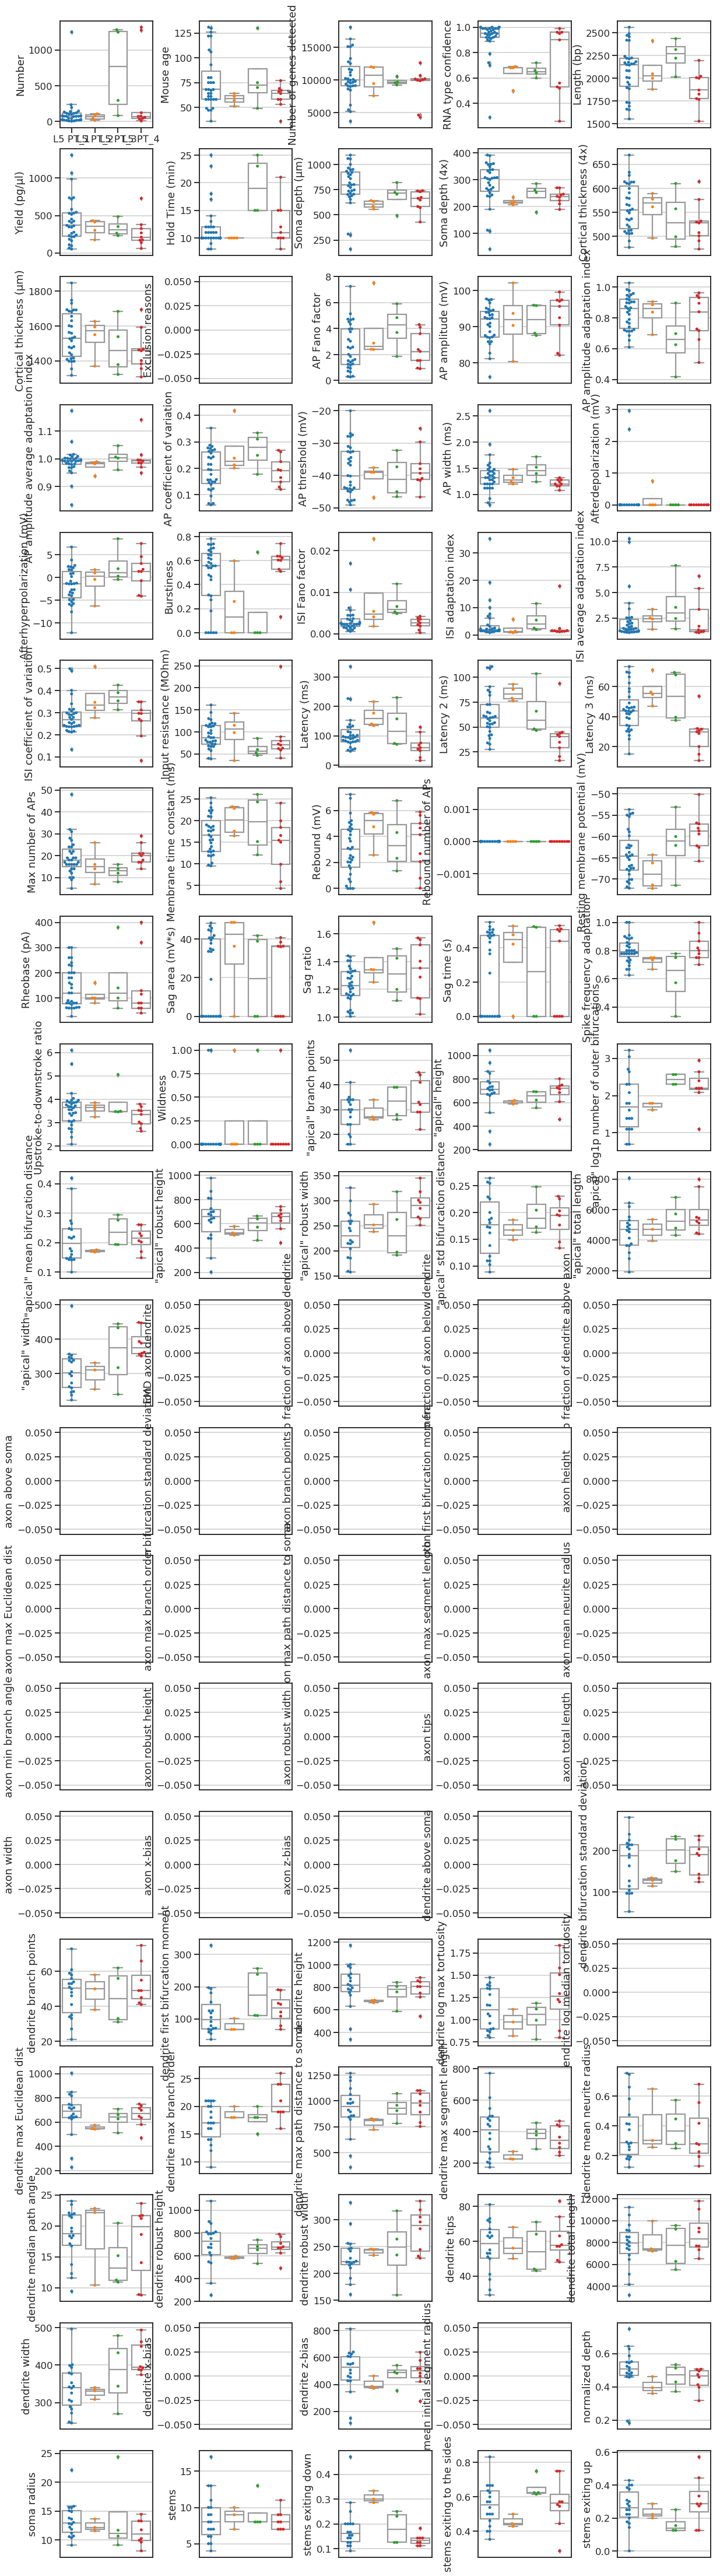

In [127]:
n = len(cols)
nx = 5
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(nx*4, ny*4))
axs = axs.flatten()
for i, (col, ax) in enumerate(zip(cols, axs)):
    sns.boxplot(ax=ax, y=col, x='RNA type', data=meta, color='white', order=['L5 PT_1', 'L5 PT_2', 'L5 PT_3', 'L5 PT_4'])
    sns.swarmplot(ax=ax, y=col, x='RNA type', data=meta, order=['L5 PT_1', 'L5 PT_2', 'L5 PT_3', 'L5 PT_4'])
    ax.set_xlabel('')
    if i != 0:
        ax.set_xticks([])
fig.subplots_adjust(wspace=0.5)
plt.show()